First, simplify the mathematical expression to make the implicit equation more manageable, and then compute the best-fit values of the parameters $\theta$, $m$, and $X$ using nonlinear regression.


Let $ x(t) $ and $y(t)$:

$$
x(t) = t \cos \theta- e^{m |t|} \sin(0.3t) \sin \theta+ X
$$

$$
y(t) = t \sin \theta+ e^{m |t|} \sin(0.3t) \cos \theta+ 42
$$


---
# Step 1: Recognize Rotation and Shift Structure

Notice that this is a rotated and shifted (by  $(X, 42) $) version of the curve  
$$
(t, e^{m|t|} \sin(0.3t))
$$




---


# Step 2: Undo the Shift

Assume
$$
X' = x - X, \quad Y' = y - 42
$$

Then,  


$$X' = t \cos \theta- e^{m |t|} \sin(0.3t) \sin k$$

$$Y' = t \sin \theta+ e^{m |t|} \sin(0.3t) \cos k$$






---
# Step 3: Invert the Rotation

Observe that this is a standard 2D rotation:

$$
\begin{pmatrix} X' \\ Y' \end{pmatrix}
=
\begin{pmatrix}
\cos \theta& -\sin \theta\\
\sin \theta& \cos k
\end{pmatrix}
\begin{pmatrix}
t \\
e^{m|t|} \sin(0.3t)
\end{pmatrix}$$

After applying the inverse (which is the transpose in this case):

$$
\begin{pmatrix}
t \\
e^{m|t|} \sin(0.3t)
\end{pmatrix}
=
\begin{pmatrix}
\cos \theta& \sin \theta\\
-\sin \theta& \cos k
\end{pmatrix}
\begin{pmatrix}
X' \\
Y'
\end{pmatrix}
$$

which gives:

$$
t = X' \cos \theta+ Y' \sin \theta= (x - X)\cos \theta+ (y - 42)\sin k
$$

$$
e^{m|t|} \sin(0.3t) = -X' \sin \theta+ Y' \cos \theta= -(x - X)\sin \theta+ (y - 42)\cos k
$$



---

# Step 4: Finding the Implicit Cartesian Equation

So, substituting for $t$, $t = X' \cos \theta+ Y' \sin \theta= (x - X)\cos \theta+ (y - 42)\sin k$:

$$
-(x - X) \sin \theta+ (y - 42) \cos \theta=
e^{m |(x - X)\cos \theta+ (y - 42)\sin k|} \sin\!\left(0.3((x - X)\cos \theta+ (y - 42)\sin k)\right)
$$


---
# Step 5: Use nonlinear regression to find $X$, $m$, and $\theta$

Estimated parameters:
  X = 55.000
  m = 0.030000
  θ = 30.000° (0.524 rad)


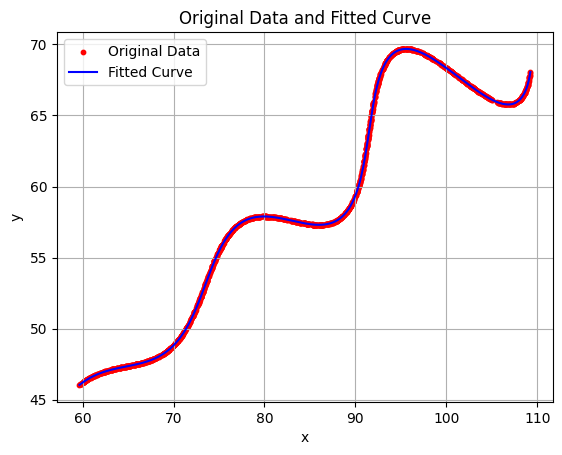

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, fsolve
import matplotlib.pyplot as plt

# Step 1: Load the  data  
df = pd.read_csv('xy_data.csv')
x_data = df['x'].values
y_data = df['y'].values

# Step 2: Define the model  
# This function represents the mathematical relationship we’re fitting.
# It comes from the implicit equation derived earlier.
def model_func(input_xy, X, m, theta_deg):
    x, y = input_xy
    theta = np.radians(theta_deg)

    # Calculating the rotated coordinate t
    t = (x - X) * np.cos(theta) + (y - 42) * np.sin(theta)
    
    # LHS of the equation
    lhs = -(x - X) * np.sin(theta) + (y - 42) * np.cos(theta)
    
    # RHS of the equation
    rhs = np.exp(m * np.abs(t)) * np.sin(0.3 * t)
    
    # The residual (difference between both sides) should be close to zero
    return lhs - rhs

# A simple wrapper for curve_fit (needed because curve_fit passes x data as one argument)
def fit_func(input_xy, X, m, theta_deg):
    return model_func(input_xy, X, m, theta_deg)

# Combine x and y into a single tuple since the function uses both
input_data = (x_data, y_data)

# Step 3: Set up the fitting parameters  
# Bounds are [min values], [max values] for (X, m, theta)
bounds = ([0, -0.05, 0], [100, 0.05, 50])

# A rough starting guess for the parameters at the middle of the bounds
initial_guess = [50, 0, 25]

# Step 4: Perform curve fitting  
# curve_fit will try to find X, m, and theta that minimize the residuals (lhs - rhs)
params, covariance = curve_fit(
    fit_func,
    input_data,
    np.zeros_like(x_data),  # target residuals are 0
    p0=initial_guess,
    bounds=bounds
)

X_fit, m_fit, theta_fit = params
theta_rad = np.radians(theta_fit)

print(f"Estimated parameters:")
print(f"  X = {X_fit:.3f}")
print(f"  m = {m_fit:.6f}")
print(f"  θ = {theta_fit:.3f}° ({theta_rad:.3f} rad)")


# What curve_fit does (Virtanen et al.): 
The `curve_fit` function here is being used to find the best values of three parameters — `X`, `m`, and `θ` (theta) — so that our **model equation** matches the data as closely as possible.


We start with given measured data points: `x_data` and `y_data`.
We assume that these points roughly follow some relationship defined by our model function `model_func`.

Here, that function is defined as:

$$
f(x, y; X, m, \theta) = \text{lhs} - \text{rhs}
$$

where

$$
\text{lhs} = -(x - X)\sin(\theta) + (y - 42)\cos(\theta)
$$

and

$$
\text{rhs} = e^{m |X|} \sin(0.3 X)
$$


Now, `curve_fit` needs a function that predicts something for each data point, and it will adjust the parameters (`X`, `m`, `θ`) to make the model output close to the observed data.
In this case, we’re fitting our model to minimize how far off the expression $f(x, y; X, m, \theta)$ is from zero, i.e., we want:

$$
f(x_i, y_i; X, m, \theta) = 0
$$

for all data points $(x_i, y_i)$.

So when we call:

params, covariance = curve_fit(fit_func, input_data, np.zeros_like(x_data),
                               p0=initial_guess, bounds=bounds)
What happens is:

- `input_data = (x_data, y_data)` → our known measurements (the x and y values given)
- `np.zeros_like(x_data)` → the target values (we want the model’s output to be as close to zero as possible, meaning minimal residual error)
- `p0 = [X, m, θ]` → our initial guesses for the parameters
- `bounds` → the upper and lower limits within which the parameters are allowed to vary

`curve_fit` then uses numerical optimization to adjust `X`, `m`, and `θ` step by step, minimizing the difference between the model’s predicted values and the zero target (the residuals). Essentially, it’s finding the best-fitting combination of parameters.

more formally, it solves the optimization problem:

$$
\min_{X, m, \theta} \; S(X, m, \theta)
$$

where

$$
S(X, m, \theta) = \sum_i \Big[ f(x_i, y_i; X, m, \theta) - 0 \Big]^2
$$


Intuitively, we can think of it as:

- Shifting by $X$
- Rotating by $\theta$
- Scaling or shaping by $m$

until the model curve passes as closely as possible through all your observed points.

The optimized parameters are returned as:

$$
X_{\text{fit}}, \, m_{\text{fit}}, \, \theta_{\text{fit}}
$$

which represent the values that minimize the total squared residual:

$$
S_{\min} = \sum_i f(x_i, y_i; X_{\text{fit}}, m_{\text{fit}}, \theta_{\text{fit}})^2
$$

So, in summary:  
`curve_fit` finds the best combination of $X$, $m$, and $\theta$ such that our implicit equation

$$
f(x, y; X, m, \theta) = 0
$$

reference:
Virtanen, Pauli, et al. “scipy.optimize.curve_fit — SciPy v1.16.0 Manual.” SciPy Documentation, SciPy.org, 2024, https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

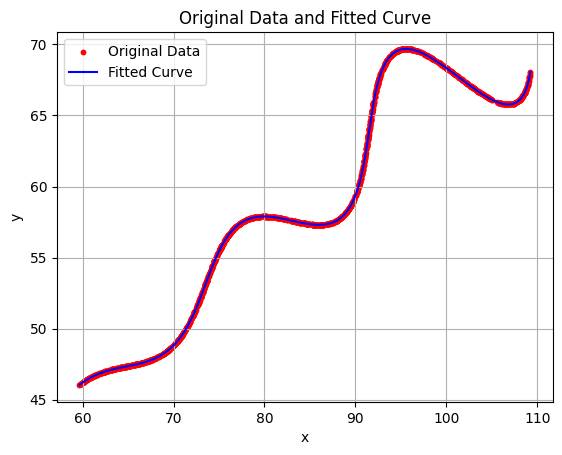

In [88]:

# Step 5: Visualizing the result  
# Plot the original data points
plt.scatter(x_data, y_data, color='red', label='Original Data', s=10)

# Creating a smooth range of x-values to plot the fitted curve
x_fit_range = np.linspace(min(x_data), max(x_data), 1500)

#   Step 6: Solve for y at each x (since the equation is implicit)  
# We'll use fsolve to find the y value that satisfies the equation for each x.
def y_from_x(x):
    def func_y(y):
        # Calculate t and the two sides of the equation again, now for a given x and y
        t = (x - X_fit) * np.cos(theta_rad) + (y - 42) * np.sin(theta_rad)
        lhs = -(x - X_fit) * np.sin(theta_rad) + (y - 42) * np.cos(theta_rad)
        rhs = np.exp(m_fit * np.abs(t)) * np.sin(0.3 * t)
        return lhs - rhs  # want this to be zero

    # Start the solver near the average of the original y-values
    y_solution, = fsolve(func_y, np.mean(y_data))
    return y_solution

# Compute all y-values for the fitted curve
y_fit_curve = np.array([y_from_x(x) for x in x_fit_range])

#   Step 7: Plot everything together  
plt.plot(x_fit_range, y_fit_curve, color='blue', label='Fitted Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Original Data and Fitted Curve')
plt.legend()
plt.grid(True)
plt.show()
